In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

from tqdm.notebook import tqdm

from joblib import delayed, Parallel

import matplotlib.pyplot as plt
import itertools

In [2]:
ds = load_iris(as_frame=True)
X = ds.data
y = ds.target

for i, n in enumerate(ds.target_names):
    y.replace(i, n, inplace=True) 

In [3]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [4]:
ad = DecisionTreeClassifier(max_depth=3)
ad.fit(X_treino, y_treino)

DecisionTreeClassifier(max_depth=3)

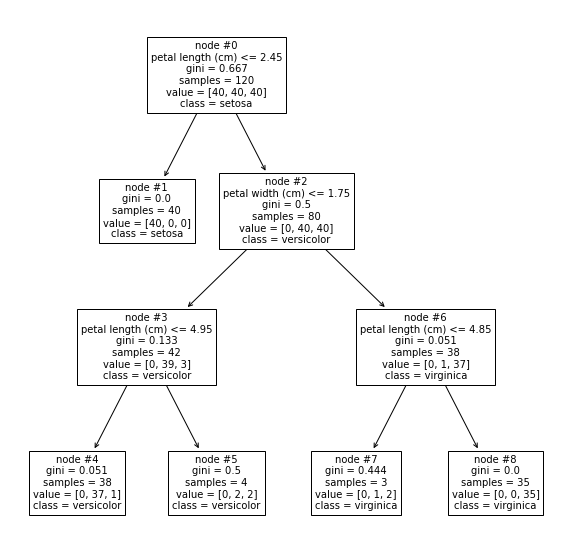

In [5]:
plt.figure(figsize=(10, 10))
plot_tree(ad, class_names=ad.classes_, feature_names=X.columns, node_ids=True)
plt.show()

In [6]:
pred = ad.predict(X_teste)
print(classification_report(y_teste, pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



In [7]:
def selecionar_melhor_ad(X_treino, X_val, y_treino, y_val, n_jobs=4, cv_folds=None,
                         max_depths=[None], min_samples_leafs=[1], min_samples_splits=[2]):
    
    def treinar_ad(max_depth, min_samples_leaf, min_samples_split, X_treino, X_val, y_treino, y_val):
        ad = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, random_state=1)
        ad.fit(X_treino, y_treino)
        pred = ad.predict(X_val)
        if len(set(y_treino)) > 2:
            return f1_score(y_val, pred, average='weighted')
        else:
            return f1_score(y_val, pred)
    
    
    if cv_folds is not None:
        #Se for pra usar validação cruzada, usar GridSearchCV
        ad = DecisionTreeClassifier()
        
        #Configurar os valores que serão testados para cada parâmetro
        pg = {
            'max_depth' : max_depths,
            'min_samples_leaf' : min_samples_leafs, 
            'min_samples_split' : min_samples_splits,
        }
        
        score_fn = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'
        
        ad = GridSearchCV(ad, pg, cv=cv_folds, n_jobs=n_jobs, scoring=score_fn)
        #Passar todos os dados (Treino e Validação) para realizar a seleção dos parâmetros.
        ad.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        
        melhor_comb = (ad.best_params_['max_depth'], ad.best_params_['min_samples_leaf'], ad.best_params_['min_samples_split'])
        melhor_val = ad.best_score_
        
    else:
        combinacoes_parametros = list(itertools.product(max_depths, min_samples_leafs, min_samples_splits))
        f1s_val = Parallel(n_jobs=n_jobs)(delayed(treinar_ad)
                                         (md, msl, mss, X_treino, X_val, y_treino, y_val) for md, msl, mss in combinacoes_parametros)

        melhor_val = max(f1s_val)
        melhor_comb = combinacoes_parametros[np.argmax(f1s_val)]
        melhor_md, melhor_msl, melhor_mss = melhor_comb

        ad = DecisionTreeClassifier(max_depth=melhor_md, min_samples_leaf=melhor_msl, min_samples_split=melhor_mss, random_state=1)
        ad.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return ad, melhor_comb, melhor_val

In [52]:
def do_cv_ad(X, y, cv_splits, param_cv_folds=None, **params_kwargs):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    f1s = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ad, melhor_comb, _ = selecionar_melhor_ad(X_treino, X_val, y_treino, y_val, cv_folds=param_cv_folds, **params_kwargs)
        pred = ad.predict(X_teste)

        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s.append(f1)
        
        pgb.update(1)
        
    pgb.close()
    
    return f1s

In [85]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

In [87]:
ad_f1_md = do_cv_ad(X.values, y, 10, 10, **{'max_depths': [None, 2, 3, 4 ,5]})
imprimir_estatisticas(ad_f1_md)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.93 +- 0.06, min: 0.80, max: 1.00


In [89]:
ad_f1_msl = do_cv_ad(X.values, y, 10, 10, **{'min_samples_leafs': [1, 3, 5, 10, 15, 20, 30]})
imprimir_estatisticas(ad_f1_msl)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.95 +- 0.07, min: 0.80, max: 1.00


In [91]:
ad_f1_msp = do_cv_ad(X.values, y, 10, 10, **{'min_samples_splits': [4, 8, 16, 32, 40]})
imprimir_estatisticas(ad_f1_msp)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.94 +- 0.06, min: 0.80, max: 1.00


In [94]:
ad_f1_all = do_cv_ad(X.values, y, 10, 10, **{'min_samples_splits': [4, 8, 16, 32, 40], 
                                             'min_samples_leafs': [1, 3, 5, 10, 15, 20, 30], 
                                             'max_depths': [None, 2, 3, 4 ,5]})
imprimir_estatisticas(ad_f1_all)

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Resultados: 0.95 +- 0.07, min: 0.80, max: 1.00
